In [2]:
import duckdb

con = duckdb.connect()

con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")

con.execute("""
SET s3_region='us-east-1';
SET s3_use_ssl=true;
SET s3_url_style='path';
""")

con.execute("SELECT 'DuckDB ready'").fetchall()


[('DuckDB ready',)]

In [6]:
con.execute("""
CREATE OR REPLACE VIEW animal_activity AS
SELECT *
FROM read_parquet(
  's3://jax-envision-public-data/study_1001/2025v3.3/tabular/*/*/animal_activity_db.parquet',
  hive_partitioning = true
)
""")


In [8]:
con.execute("DESCRIBE animal_activity").fetchdf()


,column_name,column_type,null,key,default,extra
0,predicted_identity,VARCHAR,YES,None,None,None
1,time,TIMESTAMP_NS,YES,None,None,None
2,resolution,BIGINT,YES,None,None,None
3,name,VARCHAR,YES,None,None,None
4,value,DOUBLE,YES,None,None,None
5,units,VARCHAR,YES,None,None,None
6,version_str,VARCHAR,YES,None,None,None
7,organization_id,BIGINT,YES,None,None,None
8,cage_id,BIGINT,YES,None,None,None
9,study_id,BIGINT,YES,None,None,None


In [10]:
con.execute("""
SELECT DISTINCT name
FROM animal_activity
LIMIT 20
""").fetchdf()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,name
0,animal_bouts.locomotion
1,animal_bouts.climbing
2,animal_bouts.active
3,animal_bouts.inactive


In [32]:
con.execute("""
SELECT cage_id, COUNT(DISTINCT animal_id) AS n_mice
FROM animal_activity
GROUP BY cage_id
HAVING n_mice = 3
LIMIT 5
""").fetchdf()


,cage_id,n_mice
0,4918,3
1,4932,3
2,4921,3
3,4925,3
4,4929,3


In [34]:
con.execute("""
CREATE OR REPLACE VIEW activity_one_cage AS
SELECT *
FROM animal_activity
WHERE cage_id = 4917
""")


In [36]:
con.execute("""
CREATE OR REPLACE VIEW locomotion_clean AS
SELECT
    animal_id,
    date,
    value
FROM activity_one_cage
WHERE name = 'animal_bouts.locomotion'
""")


In [38]:
con.execute("""
CREATE OR REPLACE VIEW daily_locomotion AS
SELECT
    animal_id,
    date,
    SUM(value) AS locomotion_total
FROM locomotion_clean
GROUP BY animal_id, date
""")


In [40]:
df = con.execute("""
SELECT *
FROM daily_locomotion
ORDER BY animal_id, date
""").fetchdf()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

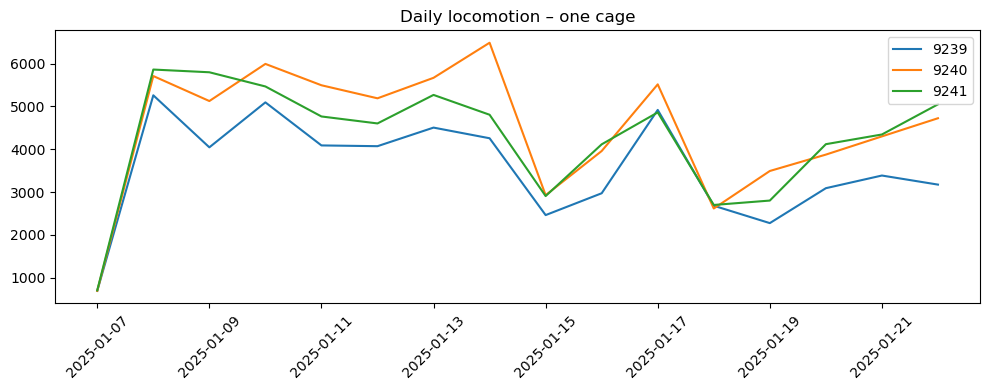

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

for animal_id, g in df.groupby("animal_id"):
    plt.plot(g["date"], g["locomotion_total"], label=str(animal_id))

plt.legend()
plt.title("Daily locomotion – one cage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [44]:
con.execute("""
CREATE OR REPLACE VIEW daily_locomotion_norm AS
SELECT
    animal_id,
    date,
    locomotion_total,
    locomotion_total
      - AVG(locomotion_total) OVER (PARTITION BY date)
        AS locomotion_delta
FROM daily_locomotion
""")


In [46]:
df = con.execute("""
SELECT *
FROM daily_locomotion_norm
ORDER BY animal_id, date
""").fetchdf()


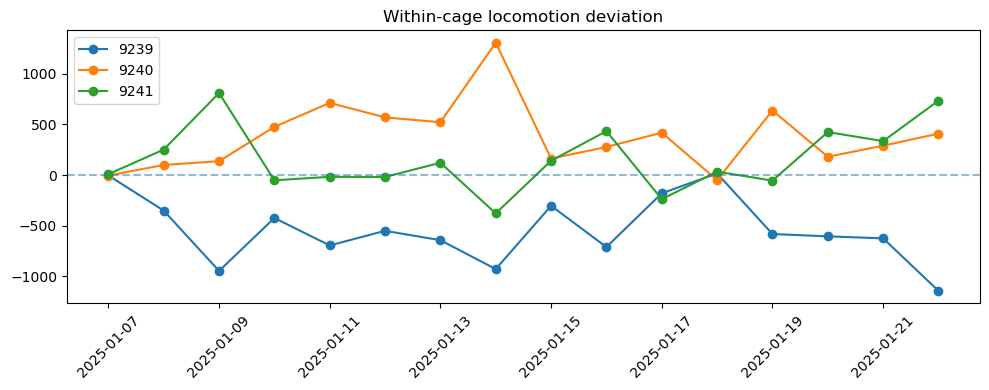

In [48]:
plt.figure(figsize=(10,4))

for animal_id, g in df.groupby("animal_id"):
    plt.plot(g["date"], g["locomotion_delta"], marker="o", label=str(animal_id))

plt.axhline(0, linestyle="--", alpha=0.5)
plt.legend()
plt.title("Within-cage locomotion deviation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [50]:
con.execute("""
CREATE OR REPLACE VIEW putative_estrus_days AS
SELECT
    animal_id,
    date,
    locomotion_delta,
    CASE
        WHEN locomotion_delta > 0
             AND locomotion_delta >
                 0.5 * STDDEV_POP(locomotion_delta)
                     OVER (PARTITION BY animal_id)
        THEN 1
        ELSE 0
    END AS is_putative_estrus
FROM daily_locomotion_norm
""")


In [52]:
df = con.execute("""
SELECT *
FROM putative_estrus_days
ORDER BY animal_id, date
""").fetchdf()


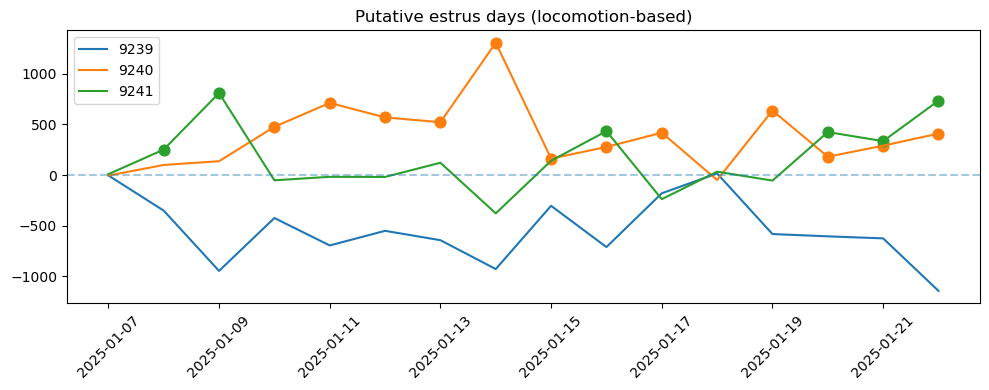

In [54]:
plt.figure(figsize=(10,4))

for animal_id, g in df.groupby("animal_id"):
    plt.plot(g["date"], g["locomotion_delta"], label=str(animal_id))
    plt.scatter(
        g.loc[g["is_putative_estrus"] == 1, "date"],
        g.loc[g["is_putative_estrus"] == 1, "locomotion_delta"],
        s=60
    )

plt.axhline(0, linestyle="--", alpha=0.4)
plt.legend()
plt.title("Putative estrus days (locomotion-based)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [58]:
con.execute("""
CREATE OR REPLACE VIEW animal_drinking AS
SELECT *
FROM read_parquet(
  's3://jax-envision-public-data/study_1001/2025v3.3/tabular/*/*/animal_drinking.parquet',
  hive_partitioning = true
)
""")


In [84]:
con.execute("""
CREATE OR REPLACE VIEW drinking_one_cage AS
SELECT
    animal_id,
    cage_id,
    date,
    value AS drinking_value
FROM animal_drinking
WHERE cage_id = 4917
""")


In [86]:
con.execute("""
CREATE OR REPLACE VIEW daily_drinking AS
SELECT
    animal_id,
    date,
    SUM(drinking_value) AS total_drinking
FROM drinking_one_cage
GROUP BY animal_id, date
""")


In [87]:
con.execute("""
CREATE OR REPLACE VIEW daily_drinking_norm AS
SELECT
    animal_id,
    date,
    total_drinking,
    total_drinking - AVG(total_drinking) OVER (PARTITION BY date) AS drinking_delta
FROM daily_drinking
""")


In [88]:
con.execute("""
CREATE OR REPLACE VIEW activity_drinking_combined AS
SELECT
    l.animal_id,
    l.date,
    l.locomotion_delta,
    d.drinking_delta
FROM daily_locomotion_norm l
LEFT JOIN daily_drinking_norm d
ON l.animal_id = d.animal_id AND l.date = d.date
""")


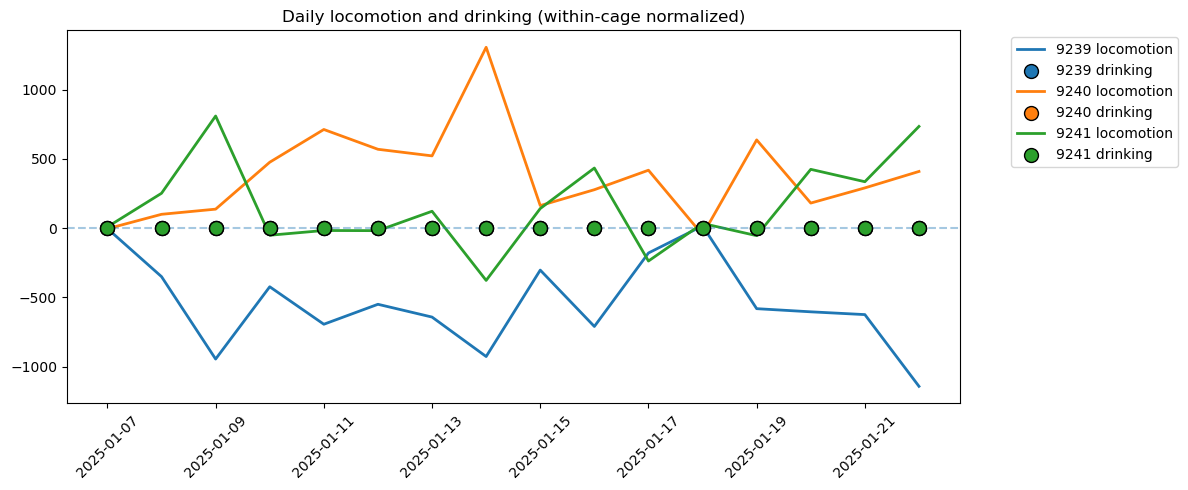

In [89]:
import matplotlib.dates as mdates

df["drinking_delta"] = df["drinking_delta"].fillna(0)

mouse_ids = df["animal_id"].unique()
colors = plt.cm.tab10.colors  
color_map = {mouse_id: colors[i % 10] for i, mouse_id in enumerate(mouse_ids)}

plt.figure(figsize=(12,5))

for animal_id, g in df.groupby("animal_id"):
    color = color_map[animal_id]
    plt.plot(g["date"], g["locomotion_delta"], label=f"{animal_id} locomotion", color=color, linewidth=2)
    plt.scatter(
        g["date"], g["drinking_delta"],
        label=f"{animal_id} drinking", color=color, edgecolor='black',
        s=100, marker='o', alpha=1.0, zorder=5
    )

plt.axhline(0, linestyle="--", alpha=0.4)
plt.legend(bbox_to_anchor=(1.05,1))
plt.title("Daily locomotion and drinking (within-cage normalized)")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()


In [94]:
df_raw = con.execute("""
SELECT l.animal_id, l.date, l.locomotion_delta, d.total_drinking
FROM daily_locomotion_norm l
LEFT JOIN daily_drinking d
ON l.animal_id = d.animal_id AND l.date = d.date
ORDER BY l.animal_id, l.date
""").fetchdf()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

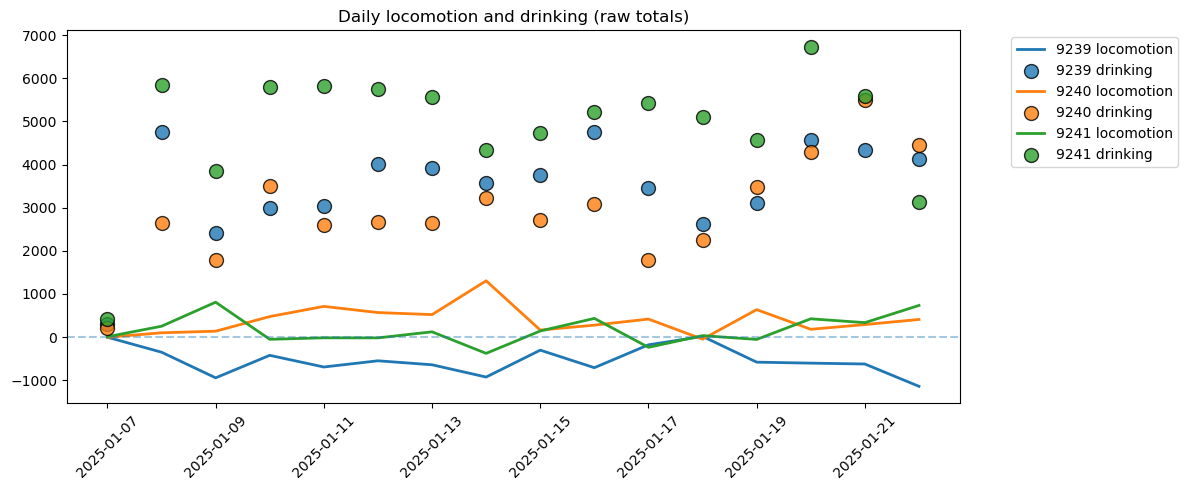

In [96]:
plt.figure(figsize=(12,5))

for animal_id, g in df_raw.groupby("animal_id"):
    plt.plot(g["date"], g["locomotion_delta"], label=f"{animal_id} locomotion", linewidth=2)
    
    plt.scatter(
        g["date"], g["total_drinking"],
        label=f"{animal_id} drinking",
        s=100, alpha=0.8, edgecolor='black', zorder=5
    )

plt.axhline(0, linestyle="--", alpha=0.4)
plt.legend(bbox_to_anchor=(1.05,1))
plt.title("Daily locomotion and drinking (raw totals)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/bp/jv7_b5rd60j6_rlflqn6zd580000gn/T/ipykernel_76723/2330544245.py:21: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax1.legend(lines_labels + scat_labels, bbox_to_anchor=(1.05,1))


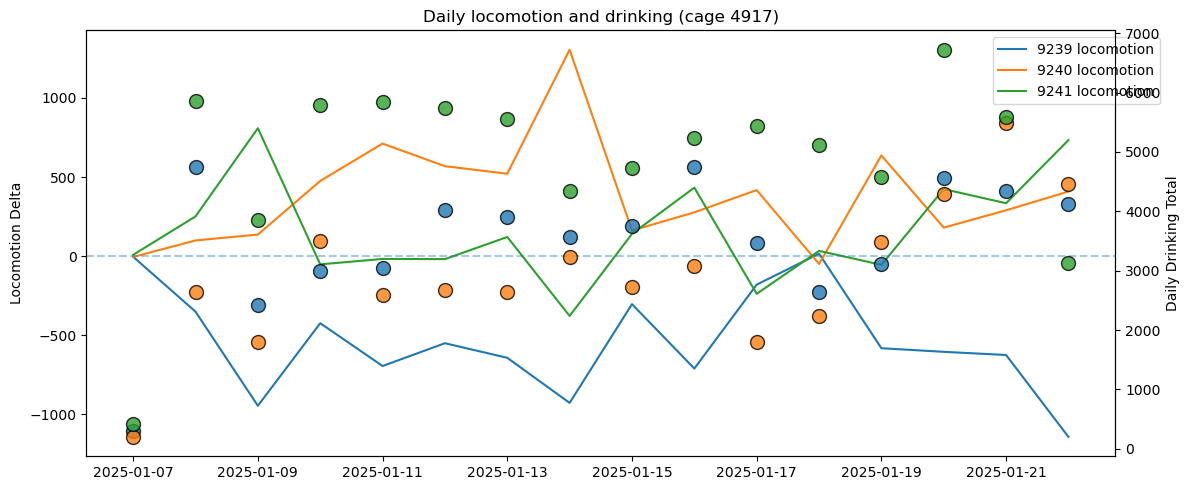

In [98]:
fig, ax1 = plt.subplots(figsize=(12,5))

for animal_id, g in df_raw.groupby("animal_id"):
    ax1.plot(g["date"], g["locomotion_delta"], label=f"{animal_id} locomotion")
ax1.set_ylabel("Locomotion Delta")
ax1.axhline(0, linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
for animal_id, g in df_raw.groupby("animal_id"):
    ax2.scatter(
        g["date"], g["total_drinking"], label=f"{animal_id} drinking",
        s=100, alpha=0.8, edgecolor='black', zorder=5
    )
ax2.set_ylabel("Daily Drinking Total")

lines_labels = [l.get_label() for l in ax1.get_lines()]
scat_labels = [f"{animal_id} drinking" for animal_id in df_raw["animal_id"].unique()]
ax1.legend(lines_labels + scat_labels, bbox_to_anchor=(1.05,1))

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title("Daily locomotion and drinking (cage 4917)")
plt.tight_layout()
plt.show()
